# Compositional Abstraction Error

One of the key requirement we imposed on abstraction is *compositionality*. We have two forms of compositionality:
- If $\alpha_1$ is a zero-error abstraction from $\mathcal{M}$ to $\mathcal{M'}$, and $\alpha_2$ is a zero-error abstraction from $\mathcal{M'}$ to $\mathcal{M''}$, then we want the composition $\alpha_1 \circ \alpha_1$ to be a zero-error abstraction from $\mathcal{M}$ to $\mathcal{M''}$.
- If $\alpha_1$ is an abstraction from $\mathcal{M}$ to $\mathcal{M'}$ with error $e_1$, and $\alpha_2$ is an abstraction from $\mathcal{M'}$ to $\mathcal{M''}$ with error $e_2$, then we want the composition $\alpha_1 \circ \alpha_1$ to be an abstraction from $\mathcal{M}$ to $\mathcal{M''}$ with error bounded by $e_1+e_2$.

In this notebook we show the importance of selecting a proper metric to evaluate the abstraction error by showing how different metrics may fail in guaranteeing compositionality. To do this we  implement the example of SCM abstraction presented in Section 1 of [Rischel2021]. In particular we confirm experimentally that measures of abstraction error relying on KL divergence are not composable, while JS distance may provide a suitable measure.

This notebook was developed in order to offer a practical implementation of the ideas about abstraction error discussed in [Rischel2020] and [Rischel2021], and to lay stonger foundations to further work with the idea of abstraction of causal models. The notebook is structured as follows: 
- Setup of standard and custom libraries (Section 2)
- Definition of the models M0 and M1 (Section 3)
- Evaluation of abstraction error between M0 and M1 using different metrics (Section 4)
- Introduction of model M2 (Section 5)
- Evaluation of abstraction error between M1 and M2 using different metrics (Section 6)
- Evaluation of composed abstraction error computed as the sum of the abstraction error from M0 to M1 plus the abstraction error from M1 to M2 agains the abstraction error from M0 to M2 using different metrics (Section 7)
- Theoretical considerations about the choice of the metrics (Section 8)

DISCLAIMER 1: the notebook refers to ideas from *causality* and *category theory* for which only a quick definition is offered. Useful references for causality are [Pearl2009,Peters2017], while for category theory are [Spivak2014,Fong2018].

DISCLAIMER 2: mistakes are in all likelihood due to misunderstandings by the notebook author in reading [Rischel2020] and [Rischel2021]. Feedback very welcome! :)

# Setup

## Importing libraries and defining parameters

We start by importing libraries.

In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from scipy.spatial import distance
import networkx as nx

We select a number of samples for our simulations.

In [2]:
n_samples = 10**6

For reproducibility, and for discussing our results in this notebook, we set a random seed to $1985$.

In [3]:
np.random.seed(1985)

Notice that in this notebook we write simple implementations of our models without relying on *pgmpy*. Also we do not import our own Abstraction objects from *src.SCMMappings* because all abstractions will be trivial identities.

# Models M0 and M1

## SCM M0

We start by defining the SCM for Model $\mathcal{M}$ specified in the example in Section 1.4 of [Rischel2021].

A SCM [Pearl2009] is defined by a set of *exogenous variables* $\mathcal{E}$, a set of *endogenous variables* $\mathcal{X}$, a set of structural functions $\mathcal{F}$ associated with the endogenous variables, and a set of probability distribution $\mathcal{P}$ associated with the exogenous variables.

In the case of our model $\mathcal{M}$ we have:
- $\mathcal{E} = \{E_{A1}, E_{A2}, E_{T}\}$
- $\mathcal{X} = \{{A1}, {A2}, {T}\}$
- $\mathcal{F} = \{f_{A1}(E_{A1}), f_{A2}(E_{A2}), f_{T}({A1}, {A2}, E_{T})\}$
- $\mathcal{P} = \{P_{E_{A1}}, P_{E_{A2}}, P_{E_T}\}$

Let's visualize the DAG associated with $\mathcal{M}$:

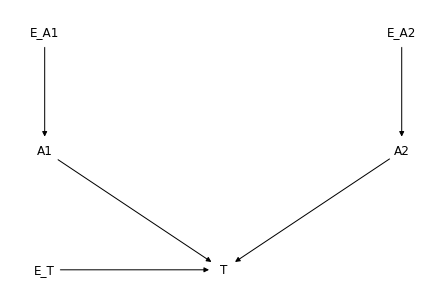

In [4]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['E_A1', 'E_A2', 'E_T', 'A1', 'A2', 'T']
edges = [('E_A1','A1'), ('E_A2','A2'), ('E_T','T'), ('A1','T'), ('A2','T')]
nodes_pos = {'E_A1':(-1, 2), 'E_A2':(1, 2), 'E_T':(-1, 0), 'A1':(-1, 1), 'A2':(1, 1), 'T':(0, 0)}
nodes_lbl = {'E_A1':'E_A1', 'E_A2':'E_A2', 'E_T':'E_T', 'A1':'A1', 'A2':'A2', 'T':'T'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

In model $\mathcal{M}$, the probability distributions are specified as:
- $P_{E_{A1}} = \mathtt{Unif}(1,100)$
- $P_{E_{A2}} = \mathtt{Unif}(1,100)$
- $P_{E_{T}} = p_T$

where $\mathtt{Unif}(1,100)$ is a uniform discrete distribution on $\{1,2,...,100\}$, and $p_T$ is a custom distribution.

Moreover, the structural function are specified as:
- $f_{A1}(E_{A1}) = E_{A1}$
- $f_{A2}(E_{A2}) = E_{A2}$
- $f_{T}(E_{A1},E_{A2},T) = p_T$

### Simplified SCM M0

Performing a push-forward of the probability distributions from the exogenous nodes over the endogenous nodes, we can simplify the model and consider only the set of variables $\mathcal{X}$. We can then represent the same model $\mathcal{M}$ as:

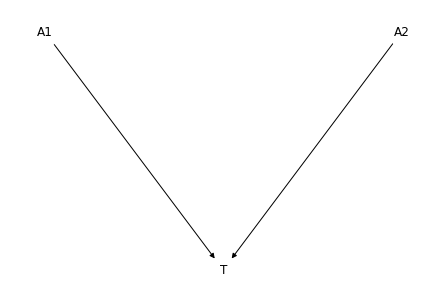

In [5]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['A1', 'A2', 'T']
edges = [('A1','T'), ('A2','T')]
nodes_pos = {'A1':(-1, 1), 'A2':(1, 1), 'T':(0, 0)}
nodes_lbl = {'A1':'A1', 'A2':'A2', 'T':'T'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

Consistently with [Rischel2021], we have:
- $A1$ and $A2$ as random variables with distribution $\mathtt{Unif}(1,100)$
- $T$ as a random variable with a probability distribution specified by:

\begin{cases}
P(T=n\vert A{1}=100,A{2}=100)=\frac{1}{Z_{1}}\frac{1}{n^{2}}\\
P(T=n\vert A{1}=100,A{2}\neq100)=\frac{1}{Z_{2}}\frac{1}{n^{3}}\\
P(T=n\vert A{1}\neq100)=\frac{1}{Z_{3}}\frac{1}{100^{n}}
\end{cases}

where $Z_1,Z_2,Z_3$ are normalizing constants.

### Implementation of M0

We can now implement the model as a simple class with two methods:
- *\__init__()*: setting up the probability distributions of interest by computing normalizing constants and the distributions; notice that because of underflow the probability distribution *px3* has to be cut and manually set to zero.
- *sample()*: returning a sample from the model.

In [6]:
class model0():
    def __init__(self):
        Ts = np.array(list(range(100)))+1
        Z1 = np.sum((1./Ts)**2)
        Z2 = np.sum((1./Ts)**3)
        Z3 = np.sum((1./100)**Ts)
        
        self.px1 = (1/Z1) / Ts**2
        self.px2 = (1/Z2) / Ts**3
        self.px3 = (1/Z3) / 100**Ts
        self.px3[np.isinf(self.px3)]=0
        self.px3[self.px3<5e-15]=0
        
    def sample(self):
        A1 = scipy.random.randint(1,101)
        A2 = scipy.random.randint(1,101)
        
        if(A1==100 and A2==100): 
            sample = scipy.random.multinomial(1,self.px1)
                    
        elif(A1==100):
            sample = scipy.random.multinomial(1,self.px2)
        
        else:
            sample = scipy.random.multinomial(1,self.px3)
        
        return A1, A2, np.where(sample==1)[0][0] + 1

We instantiate model $\mathcal{M}$.

In [7]:
M0 = model0()

/var/folders/26/t485z2v13gxcnm9hq0qjdj9h0000gn/T/ipykernel_24101/2617224678.py:10: RuntimeWarning: divide by zero encountered in true_divide
  self.px3 = (1/Z3) / 100**Ts


### Running M0

To examine the model we run a Monte Carlo-like simulation collecting $10^6$ samples.

In [8]:
data0 = np.zeros((n_samples,3))

for i in tqdm(range(n_samples)):
    data0[i,:] = M0.sample()

100%|██████████████████████████████| 1000000/1000000 [00:10<00:00, 91709.72it/s]


We plot the distributions of $A1$, $A2$ and $T$.

Text(0.5, 1.0, 'P(T)')

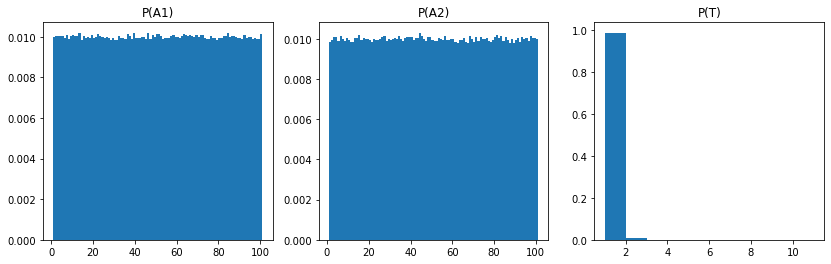

In [9]:
fig,ax = plt.subplots(1,3, figsize=(14,4))

ax[0].hist(data0[:,0],bins=np.array(list(range(101)))+1,density=True)
ax[0].set_title('P(A1)')

ax[1].hist(data0[:,1],bins=np.array(list(range(101)))+1,density=True)
ax[1].set_title('P(A2)')

ax[2].hist(data0[:,2],bins=np.array(list(range(11)))+1,density=True)
ax[2].set_title('P(T)')

As obvious, $A1$ and $A2$ are approximately uniformly distributed in the interval $[1,100]$. $P(T)$ is heavily skewed towards $0$ and we plot it only on the sub-domain $[1,10]$.

We can also analyze the conditional distribution of $P(T \vert A1=k)$ for all the values of $k$ in $[1,100]$.

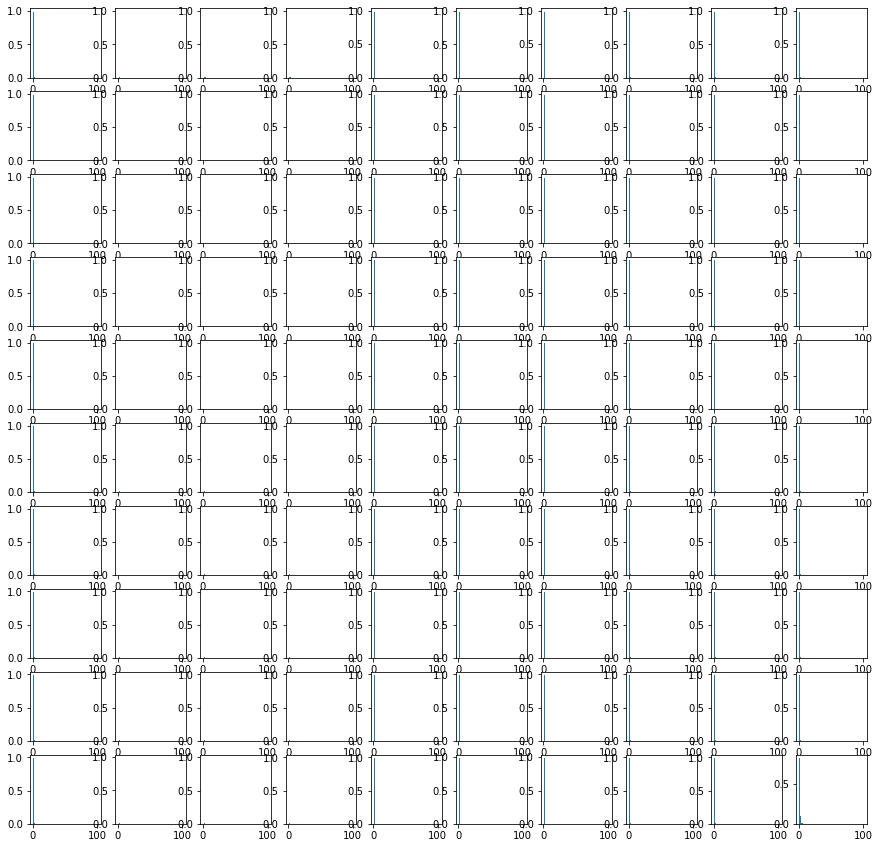

In [10]:
fig = plt.figure(figsize=(15,15))
for i in range(1, 101):
    plt.subplot(10, 10, i)
    mask = (data0[:,0] == i)
    plt.hist(data0[mask,2],bins=np.array(list(range(101)))+1,density=True)

The graphs are sparse but show a similar distribution for almost all values of $k$ with the exception, as expected, of $k=100$.

## SCM M1

Let's move on to consider an abstraction of $\mathcal{M}$ obtained by suppressing the causal edge connecting $A2$ and $T$.

Formally, the abstraction $(R,a,\alpha)$ from $\mathcal{M}$ to $\mathcal{M'}$ is trivially:
- $R={A1,A2,T}$: all variables are relevant;
- $a$: maps a low-level varible to the high-level variable with the same name;
- $\alpha_X$: all the $\alpha_X$ mappings are identities.

### Simplified SCM M1

The new abstracted model $\mathcal{M'}$ is defined on the same nodes, but it has lost an edge. We can represent this new model as:

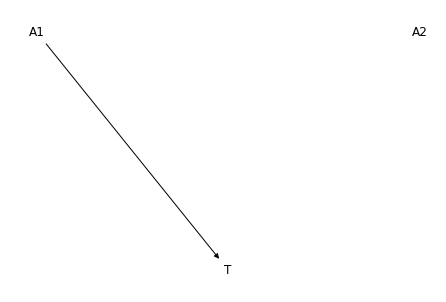

In [11]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['A1', 'A2', 'T']
edges = [('A1','T')]
nodes_pos = {'A1':(-1, 1), 'A2':(1, 1), 'T':(0, 0)}
nodes_lbl = {'A1':'A1', 'A2':'A2', 'T':'T'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

The two random variable $A1$ and $A2$ still have the same distribution $\mathtt{Unif}(1,100)$. However the distribution on the random variable of $T$ is modified so that $P_\mathcal{M'}(T \vert A1)$ is as close as possible to $P_\mathcal{M}(T \vert A1)$. 

Let's then express $P_\mathcal{M'}(T \vert A1)$. For $A1 \neq 100$ we simply have:
$$
P(T=n\vert A{1}\neq100)=\frac{1}{Z_{3}}\frac{1}{100^{n}}.
$$

For $A1 = 100$ we have:
\begin{cases}
P(T=n\vert A{1}=100)=\frac{1}{Z_{1}}\frac{1}{n^{2}} & \textrm{with probability 0.01}\\
P(T=n\vert A{1}=100)=\frac{1}{Z_{2}}\frac{1}{n^{3}} & \textrm{with probability 0.99}
\end{cases}
with a proper normalization.


### Implementation of M1

We can now implement the model $\mathcal{M'}$ as its own class. We still have two methods:
- *\__init__()*: setting up the probability distributions of interest; notice that we compute normalization constants, perform a mixture of distributions, and further normalize.
- *sample()*: returning a sample from the model.

In [12]:
class model1():
    def __init__(self):
        Ts = np.array(list(range(100)))+1
        Z1 = np.sum((1./Ts)**2)
        Z2 = np.sum((1./Ts)**3)
        Z3 = np.sum((1./100)**Ts)
        
        px1 = (1/Z1) / Ts**2
        px2 = (1/Z2) / Ts**3
        px = .01*px1 + .99*px2        
        self.px = px / np.sum(px)
        
        Z3 = np.sum((1./100)**Ts)
        self.px3 = (1/Z3) / 100**Ts
        self.px3[np.isinf(self.px3)]=0
        self.px3[self.px3<5e-15]=0
        
    def sample(self):
        A1 = scipy.random.randint(1,101)
        A2 = scipy.random.randint(1,101)
        
        if(A1==100): 
            sample = scipy.random.multinomial(1,self.px)
                    
        else:
            sample = scipy.random.multinomial(1,self.px3)
        
        return A1, A2, np.where(sample==1)[0][0] + 1

We instantiate model $\mathcal{M'}$.

In [13]:
M1 = model1()

/var/folders/26/t485z2v13gxcnm9hq0qjdj9h0000gn/T/ipykernel_24101/2249347113.py:14: RuntimeWarning: divide by zero encountered in true_divide
  self.px3 = (1/Z3) / 100**Ts


### Running M1

To examine the model we run a Monte Carlo-like simulation collecting $10^6$ samples.

In [14]:
data1 = np.zeros((n_samples,3))

for i in tqdm(range(n_samples)):
    data1[i,:] = M1.sample()

100%|██████████████████████████████| 1000000/1000000 [00:11<00:00, 88975.48it/s]


We now plot the distributions of $A1$, $A2$ and $T$ computed by $\mathcal{M}$ and $\mathcal{M'}$ side by side.

Text(0.5, 1.0, 'M2: P(T)')

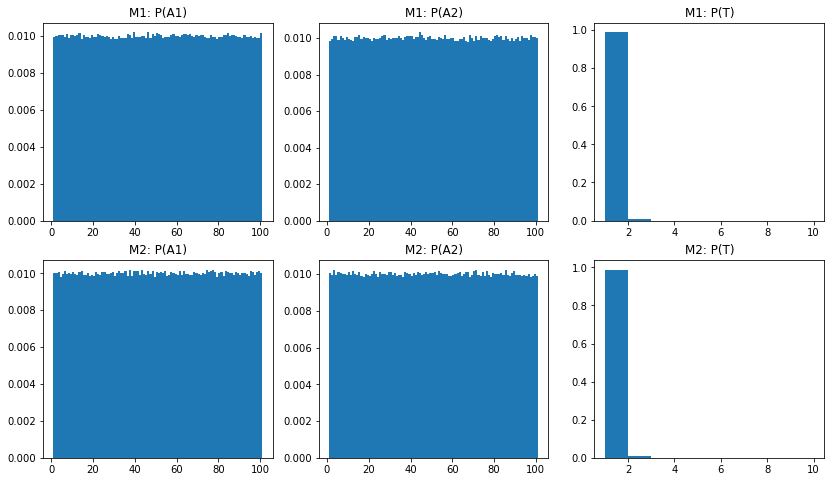

In [15]:
fig,ax = plt.subplots(2,3, figsize=(14,8))

ax[0,0].hist(data0[:,0],bins=np.array(list(range(101)))+1,density=True)
ax[0,0].set_title('M1: P(A1)')

ax[0,1].hist(data0[:,1],bins=np.array(list(range(101)))+1,density=True)
ax[0,1].set_title('M1: P(A2)')

ax[0,2].hist(data0[:,2],bins=np.array(list(range(10)))+1,density=True)
ax[0,2].set_title('M1: P(T)')

ax[1,0].hist(data1[:,0],bins=np.array(list(range(101)))+1,density=True)
ax[1,0].set_title('M2: P(A1)')

ax[1,1].hist(data1[:,1],bins=np.array(list(range(101)))+1,density=True)
ax[1,1].set_title('M2: P(A2)')

ax[1,2].hist(data1[:,2],bins=np.array(list(range(10)))+1,density=True)
ax[1,2].set_title('M2: P(T)')

The distributions in the two models look similar; specifically $P(A1)$ and $P(A2)$ are in both case randomly uniform, while $P(T)$ is heavily skewed towards $1$.

## Models M0 and M1 under intervention

When abstracting the model $\mathcal{M}$ to $\mathcal{M'}$ we are particularly interested in the (consistency of its) behavious under (specific) interventions [Rubenstein2017].

In our case, we are specifically interested in the intervention $do(A1=100,A2=100)$ and in the ensuing interventional distribution:
$$ P(T \vert do(A1=100,A2=100)). $$

Recall that, in general, *observational* and *interventional* distribution are not identitical. In other words, $P(T \vert do(A1=100,A2=100)) \neq P(T \vert A1=100,A2=100)$. 

The intervention $do(A1=100,A2=100)$ is best understood as an intervention on model $\mathcal{M}$ (or $\mathcal{M'}$) leading to the definition of a new model $\mathcal{M_\iota}$ (or $\mathcal{M'_\iota}$). 
In the PSCM of $\mathcal{M}$, the intervention $do(A1=100,A2=100)$ corresponds to setting the values of the endogenous variables $A1$ and $A2$ to $100$, and cutting the edge from $E_A1$ to $A1$ and the edge from $E_A2$ to $A2$. Graphically this corresponds to the new model $\mathcal{M_\iota}$:

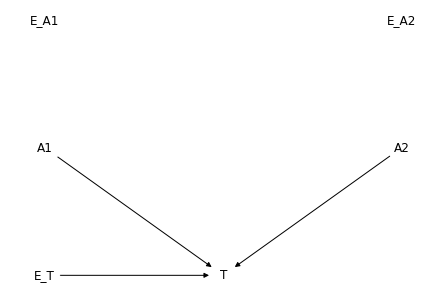

In [16]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['E_A1', 'E_A2', 'E_T', 'A1', 'A2', 'T']
edges = [('E_T','T'), ('A1','T'), ('A2','T')]
nodes_pos = {'E_A1':(-1, 2), 'E_A2':(1, 2), 'E_T':(-1, 0), 'A1':(-1, 1), 'A2':(1, 1), 'T':(0, 0)}
nodes_lbl = {'E_A1':'E_A1', 'E_A2':'E_A2', 'E_T':'E_T', 'A1':'A1', 'A2':'A2', 'T':'T'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

In the simplified PSCM, after the pushforward of the probability distributions in $\mathcal{M_\iota}$, this trivially correspond to the model where the random variables $A1$ and $A2$ are set to $100$.

### Implementation of intervened M0

We now implement the model $\mathcal{M}$ after the intervention $do(A1=100,A2=100)$. Notice that, while for computational reasons we could simplify and shorten the code, we opt for an implementation that follows the semantic of intervention more closely. That is, we keep exactly the same model, but in the *sample()* function we substitute the sampling of a uniform distribution with the fixed value of $100$.

Because of the definition of the model $\mathcal{M}$ we know the analytic formula for $P(T \vert do(A1=100,A2=100))$ in $\mathcal{M}$:
$$ P_{\mathcal{M}}(T \vert do(A1=100,A2=100)) = \frac{1}{Z_{1}}\frac{1}{n^{2}} $$

In [17]:
class model0_do():
    def __init__(self):
        Ts = np.array(list(range(100)))+1
        Z1 = np.sum((1./Ts)**2)
        Z2 = np.sum((1./Ts)**3)
        Z3 = np.sum((1./100)**Ts)
        
        self.px1 = (1/Z1) / Ts**2
        self.px2 = (1/Z2) / Ts**3
        self.px3 = (1/Z3) / 100**Ts
        self.px3[np.isinf(self.px3)]=0
        self.px3[self.px3<5e-15]=0
        
    def sample(self):
        A1 = 100
        A2 = 100
        
        if(A1==100 and A2==100): 
            sample = scipy.random.multinomial(1,self.px1)
                    
        elif(A1==100):
            sample = scipy.random.multinomial(1,self.px2)
        
        else:
            sample = scipy.random.multinomial(1,self.px3)
        
        return A1, A2, np.where(sample==1)[0][0] + 1

We instantiate model $\mathcal{M}_\iota$.

In [18]:
M0_do = model0_do()

/var/folders/26/t485z2v13gxcnm9hq0qjdj9h0000gn/T/ipykernel_24101/3399709989.py:10: RuntimeWarning: divide by zero encountered in true_divide
  self.px3 = (1/Z3) / 100**Ts


### Running of intervened M0

To examine the model we run a Monte Carlo-like simulation collecting $10^6$ samples.

In [19]:
data0_do = np.zeros((n_samples,3))

for i in tqdm(range(n_samples)):
    data0_do[i,:] = M0_do.sample()

100%|█████████████████████████████| 1000000/1000000 [00:07<00:00, 128633.99it/s]


### Implementation of intervened M1

In the same way we implement the model $\mathcal{M'}$ after the intervention $do(A1=100,A2=100)$.

Because of the definition of the model $\mathcal{M'}$ we know the analytic formula for $P(T \vert do(A1=100,A2=100))$ in $\mathcal{M'}$:
$$ P_{\mathcal{M'}}(T \vert do(A1=100,A2=100)) = \frac{1}{Z} \left[ 0.01\frac{1}{Z_1}\frac{1}{n^{2}} + 0.99\frac{1}{Z_2}\frac{1}{n^{3}} \right] $$
that is a mixture of the distribution $\frac{1}{Z_{1}}\frac{1}{n^{2}}$ (with weight $0.01$) and $\frac{1}{Z_{2}}\frac{1}{n^{3}}$ (with weight $0.99$).

In [20]:
class model1_do():
    def __init__(self):
        Ts = np.array(list(range(100)))+1
        Z1 = np.sum((1./Ts)**2)
        Z2 = np.sum((1./Ts)**3)
        Z3 = np.sum((1./100)**Ts)
        
        px1 = (1/Z1) / Ts**2
        px2 = (1/Z2) / Ts**3
        px = .01*px1 + .99*px2        
        self.px = px / np.sum(px)
        
        self.px3 = (1/Z3) / 100**Ts
        self.px3[np.isinf(self.px3)]=0
        self.px3[self.px3<5e-15]=0
        
    def sample(self):
        A1 = 100
        A2 = 100
        
        if(A1==100): 
            sample = scipy.random.multinomial(1,self.px)
                    
        else:
            sample = scipy.random.multinomial(1,self.px3)
        
        return A1, A2, np.where(sample==1)[0][0] + 1

We instantiate model $\mathcal{M'}_\iota$.

In [21]:
M1_do = model1_do()

/var/folders/26/t485z2v13gxcnm9hq0qjdj9h0000gn/T/ipykernel_24101/3455843883.py:13: RuntimeWarning: divide by zero encountered in true_divide
  self.px3 = (1/Z3) / 100**Ts


### Running of intervened M1

To examine the model we run a Monte Carlo-like simulation collecting $10^6$ samples.

In [22]:
data1_do = np.zeros((n_samples,3))

for i in tqdm(range(n_samples)):
    data1_do[i,:] = M1_do.sample()

100%|█████████████████████████████| 1000000/1000000 [00:07<00:00, 127936.76it/s]


### Comparison of M0 and M1 under intervention

Before moving to the formal computation of the abstraction error, we want to get an intuition of the difference between our models by plotting side by side distributions of interest, that is, $P(A1 \vert do(A1=100,A2=100))$, $P(A1 \vert do(A1=100,A2=100))$ and $P(T \vert do(A1=100,A2=100))$, both in for $\mathcal{M}_\iota$ and $\mathcal{M'}_\iota$.

Text(0.5, 1.0, 'M2: P(T|do(A1=100,A2=100))')

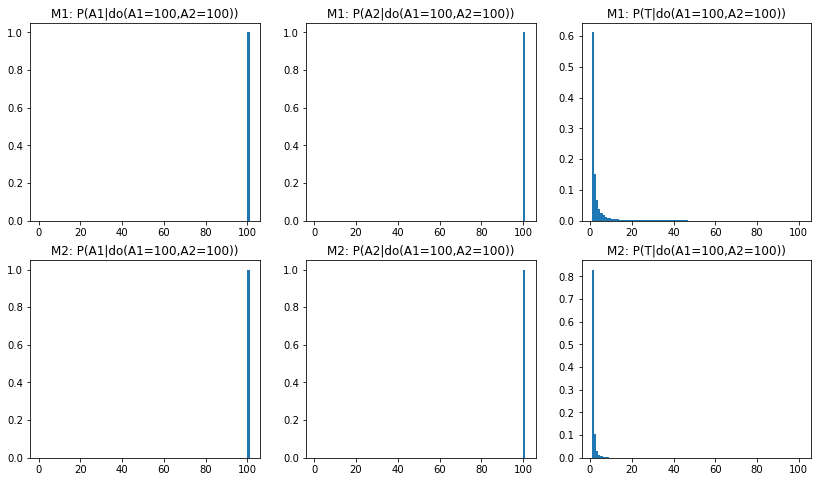

In [23]:
fig,ax = plt.subplots(2,3, figsize=(14,8))

ax[0,0].hist(data0_do[:,0],bins=np.array(list(range(101)))+1,density=True)
ax[0,0].set_title('M1: P(A1|do(A1=100,A2=100))')

ax[0,1].hist(data0_do[:,1],bins=np.array(list(range(101)))+1,density=True)
ax[0,1].set_title('M1: P(A2|do(A1=100,A2=100))')

ax[0,2].hist(data0_do[:,2],bins=np.array(list(range(101)))+1,density=True)
ax[0,2].set_title('M1: P(T|do(A1=100,A2=100))')

ax[1,0].hist(data1_do[:,0],bins=np.array(list(range(101)))+1,density=True)
ax[1,0].set_title('M2: P(A1|do(A1=100,A2=100))')

ax[1,1].hist(data1_do[:,1],bins=np.array(list(range(101)))+1,density=True)
ax[1,1].set_title('M2: P(A2|do(A1=100,A2=100))')

ax[1,2].hist(data1_do[:,2],bins=np.array(list(range(101)))+1,density=True)
ax[1,2].set_title('M2: P(T|do(A1=100,A2=100))')

Not surprisingly, $P(A1 \vert do(A1=100,A2=100))$ and $P(A1 \vert do(A1=100,A2=100))$ are trivially identical because both random variables $A1$ and $A2$ were intervened on in the same way in both models $\mathcal{M}$ and $\mathcal{M'}$.

$P(T \vert do(A1=100,A2=100))$, instead, shows a different distribution, which follows from the fact discussed above that:
$$ P_{\mathcal{M}}(T \vert do(A1=100,A2=100)) \neq P_{\mathcal{M'}}(T \vert do(A1=100,A2=100))$$
This intuitively makes sense since intervening on $A2$ affects $\mathcal{M}$ but not $\mathcal{M'}$.

# Evaluating abstraction error

In order to evaluate properly our abstraction error we will now consider the intervention of interest and measure the distance between the interventional distributions generated by following the upper and lower path in the following diagram:

$$
\begin{array}{ccc}
\mathcal{\mathcal{M}}\left[A1,A2\right] & \overset{\mathcal{\mathcal{M}}\left[\phi_{T}\right]}{\longrightarrow} & \mathcal{\mathcal{M}}\left[T\right]\\
\sideset{}{\alpha_{A1,A2}}\downarrow &  & \sideset{}{\alpha_{T}}\downarrow\\
\mathcal{\mathcal{M}}'\left[A1,A2\right] & \overset{\mathcal{\mathcal{M}}'\left[\phi_{T}\right]}{\longrightarrow} & \mathcal{\mathcal{M}}'\left[T\right]
\end{array}
$$
 
Notice that since $\alpha_{A1,A2}$ and $\alpha_{T}$ are identities, we will just compare the distance between the interventional distributions encoded by $\mathcal{\mathcal{M}}\left[\phi_{T}\right]$ and $\mathcal{\mathcal{M'}}\left[\phi_{T}\right]$.

## KL divergence

We can quantitatively evaluate the difference between $ P_{\mathcal{M}}(T \vert do(A1=100,A2=100)) $ and $ P_{\mathcal{M'}}(T \vert do(A1=100,A2=100))$ computing the (empirical) KL divergence. To do this, we first compute the *empirical* distributions by simple binning:
$$D_{KL}( \hat{P}_{\mathcal{M}}(T \vert do) \parallel \hat{P}_{\mathcal{M}'}(T \vert do))$$
where $D_{KL}$ is the KL divergence, $\hat{P}$ is the empirical distribution, and $do$ is a shortening for $do(A1=100,A2=100)$.

Notice that since some values of the empirical distribution of $\mathcal{M'}$ we have to restrict the domain over which we compute the KL divergence.

0.21759784431229037


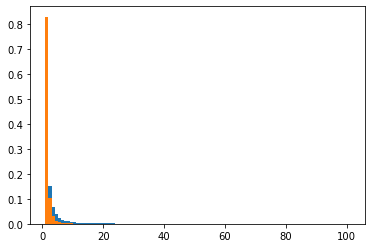

In [24]:
p_M0 = plt.hist(data0_do[:,2],bins=np.array(list(range(101)))+1,density=True)[0]
p_M1 = plt.hist(data1_do[:,2],bins=np.array(list(range(101)))+1,density=True)[0]

domain = np.where(p_M1!=0)

KL_M0_M1 = scipy.stats.entropy(p_M0[domain],p_M1[domain])
print(KL_M0_M1)

This nicely fit with the expected KL value of $0.22$ (see [Rischel2021]).

## JSD distance
We also carry the same quantitative analysis of the distribution of interest using the JSD distance:
$$D_{JSD}( \hat{P}_{\mathcal{M}}(T \vert do), \hat{P}_{\mathcal{M}'}(T \vert do))$$
where now $D_{JSD}$ is the Jensen-Shannon distance.

In [25]:
JSD_M0_M1 = distance.jensenshannon(p_M0,p_M1)
print(JSD_M0_M1)

0.199117784122986


## Wasserstein distance
Finally we consider the use of the Wasserstein distance:
$$D_{W}( \hat{P}_{\mathcal{M}}(T \vert do), \hat{P}_{\mathcal{M}'}(T \vert do))$$
where $D_{W}$ is the Wasserstein distance.

In [26]:
WD_M0_M1 = stats.wasserstein_distance(p_M0,p_M1)
print(WD_M0_M1)

0.004350320000000003


# Model M2

We further abstract $\mathcal{M'}$ by suppressing the causal edge connecting $A1$ and $T$. The new abstraction from $\mathcal{M'}$ to $\mathcal{M''}$ is also trivial defined by a new tuple $(R,a,\alpha)$ where:
- $R={A1,A2,T}$: all variables are relevant;
- $a$: maps a low-level varible to the high-level variable with the same name;
- $\alpha_X$: all the $\alpha_X$ mappings are identities.

## SCM M2

### Simplified SCM M2

The new abstracted model $\mathcal{M''}$ is defined on the same nodes, but it has no edge. We can represent this new model as:

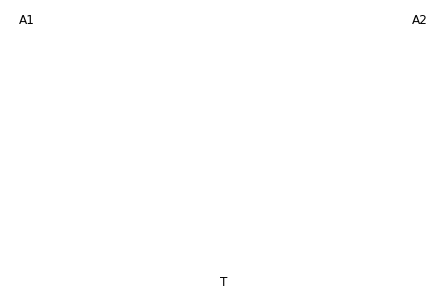

In [27]:
G = nx.DiGraph()
G.graph['dpi'] = 120

nodes = ['A1', 'A2', 'T']
edges = []
nodes_pos = {'A1':(-1, 1), 'A2':(1, 1), 'T':(0, 0)}
nodes_lbl = {'A1':'A1', 'A2':'A2', 'T':'T'}

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,nodes_pos,node_size=800,node_color='white')
_ = nx.draw_networkx_labels(G,nodes_pos,nodes_lbl)

The two random variable $A1$ and $A2$ keep the same distribution $\mathtt{Unif}(1,100)$. Instead we modify the distribution on the random variable of $T$ so that $P_\mathcal{M''}(T)$ is as close as possible to $P_\mathcal{M'}(T)$. 

Let's then express $P_\mathcal{M'}(T)$: For $A1 \neq 100$ we simply have:
$$
P(T=n)= \frac{1}{100}\frac{1}{100} \left[ \frac{1}{Z_{1}}\frac{1}{n^{2}}  \right] +
        \frac{1}{100}\frac{99}{100} \left[ \frac{1}{Z_{2}}\frac{1}{n^{3}}  \right] + 
        \frac{99}{100} \left[ \frac{1}{Z_{3}}\frac{1}{100^{n}}  \right]
$$
with a proper normalization.


### Implementation M2

We can now implement the model $\mathcal{M''}$ as its own class. We still have two methods:
- *\__init__()*: setting up the probability distributions of interest.
- *sample()*: returning a sample from the model.

In [28]:
class model2():
    def __init__(self):
        
        Ts = np.array(list(range(100)))+1
        Z1 = np.sum((1./Ts)**2)
        Z2 = np.sum((1./Ts)**3)
        Z3 = np.sum((1./100)**Ts)
        
        px1 = (1/Z1) / Ts**2
        px2 = (1/Z2) / Ts**3
        px3 = (1/Z3) / 100**Ts
        px3[np.isinf(px3)]=0
        px3[px3<5e-15]=0
        
        px = .01*.01*px1 + .01*.99*px2 + .99*px3        
        self.px = px / np.sum(px)
        
    def sample(self):
        A1 = scipy.random.randint(1,101)
        A2 = scipy.random.randint(1,101)
        
        sample = scipy.random.multinomial(1,self.px)
        
        return A1, A2, np.where(sample==1)[0][0] + 1

We instantiate model $\mathcal{M''}$.

In [29]:
M2 = model2()

/var/folders/26/t485z2v13gxcnm9hq0qjdj9h0000gn/T/ipykernel_24101/1897159575.py:11: RuntimeWarning: divide by zero encountered in true_divide
  px3 = (1/Z3) / 100**Ts


### Running M2

To examine the model we run a Monte Carlo-like simulation collecting $10^6$ samples.

In [30]:
data2 = np.zeros((n_samples,3))

for i in tqdm(range(n_samples)):
    data2[i,:] = M2.sample()

100%|██████████████████████████████| 1000000/1000000 [00:11<00:00, 90507.57it/s]


We now plot the distributions of $A1$, $A2$ and $T$ computed by $\mathcal{M}$, $\mathcal{M'}$, $\mathcal{M''}$ side by side.

Text(0.5, 1.0, 'M3: P(T)')

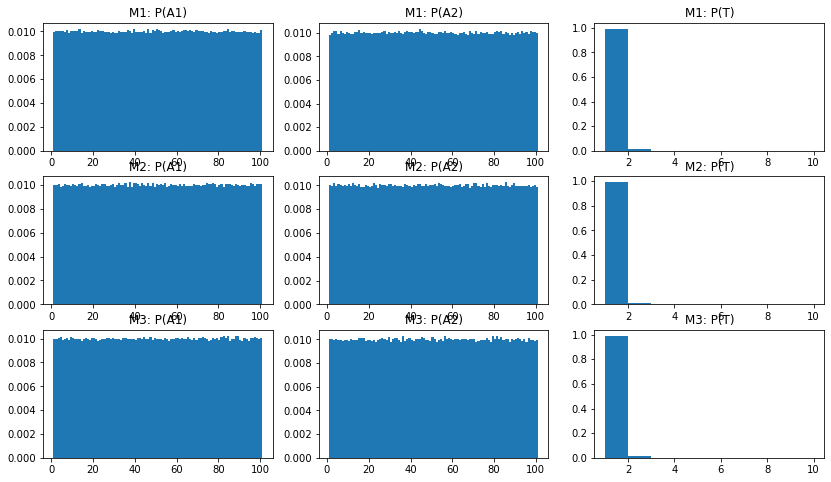

In [31]:
fig,ax = plt.subplots(3,3, figsize=(14,8))

ax[0,0].hist(data0[:,0],bins=np.array(list(range(101)))+1,density=True)
ax[0,0].set_title('M1: P(A1)')

ax[0,1].hist(data0[:,1],bins=np.array(list(range(101)))+1,density=True)
ax[0,1].set_title('M1: P(A2)')

ax[0,2].hist(data0[:,2],bins=np.array(list(range(10)))+1,density=True)
ax[0,2].set_title('M1: P(T)')

ax[1,0].hist(data1[:,0],bins=np.array(list(range(101)))+1,density=True)
ax[1,0].set_title('M2: P(A1)')

ax[1,1].hist(data1[:,1],bins=np.array(list(range(101)))+1,density=True)
ax[1,1].set_title('M2: P(A2)')

ax[1,2].hist(data1[:,2],bins=np.array(list(range(10)))+1,density=True)
ax[1,2].set_title('M2: P(T)')

ax[2,0].hist(data2[:,0],bins=np.array(list(range(101)))+1,density=True)
ax[2,0].set_title('M3: P(A1)')

ax[2,1].hist(data2[:,1],bins=np.array(list(range(101)))+1,density=True)
ax[2,1].set_title('M3: P(A2)')

ax[2,2].hist(data2[:,2],bins=np.array(list(range(10)))+1,density=True)
ax[2,2].set_title('M3: P(T)')

Again, the distributions in the two models look similar: $P(A1)$ and $P(A2)$ are in both case uniformly random, while $P(T)$ is heavily skewed towards $1$.

## Model M2 under intervention

### Implementation of intervened M2
We now consider the usual intervention $do(A1=100,A2=100)$ for model $\mathcal{M''}$ too.

Because of the graph of the model $\mathcal{M''}$ we know that the distribution of $T$ is independent from $A1$ and $A2$; so, under the above intervention, we will still have:
$$
P_{\mathcal{M''}}(T \vert do(A1=100,A2=100))= 
        \frac{1}{100}\frac{1}{100} \left[ \frac{1}{Z_{1}}\frac{1}{n^{2}}  \right] +
        \frac{1}{100}\frac{99}{100} \left[ \frac{1}{Z_{2}}\frac{1}{n^{3}}  \right] + 
        \frac{99}{100} \left[ \frac{1}{Z_{3}}\frac{1}{100^{n}}  \right].
$$

We always implement the intervened model by simply hard-coding the setting of $A1$ and $A2$ to $100$.

In [32]:
class model2_do():
    def __init__(self):
        
        Ts = np.array(list(range(100)))+1
        Z1 = np.sum((1./Ts)**2)
        Z2 = np.sum((1./Ts)**3)
        Z3 = np.sum((1./100)**Ts)
        
        px1 = (1/Z1) / Ts**2
        px2 = (1/Z2) / Ts**3
        px3 = (1/Z3) / 100**Ts
        px3[np.isinf(px3)]=0
        px3[px3<5e-15]=0
        
        px = .01*.01*px1 + .01*.99*px2 + .99*px3        
        self.px = px / np.sum(px)
        
    def sample(self):
        A1 = 100
        A2 = 100
        
        sample = scipy.random.multinomial(1,self.px)
        
        return A1, A2, np.where(sample==1)[0][0] + 1

We instantiate model $\mathcal{M''}_\iota$.

In [33]:
M2_do = model2_do()

/var/folders/26/t485z2v13gxcnm9hq0qjdj9h0000gn/T/ipykernel_24101/170723240.py:11: RuntimeWarning: divide by zero encountered in true_divide
  px3 = (1/Z3) / 100**Ts


### Running intervened M2

To examine the model we run a Monte Carlo-like simulation collecting $10^6$ samples.

In [34]:
data2_do = np.zeros((n_samples,3))

for i in tqdm(range(n_samples)):
    data2_do[i,:] = M2_do.sample()

100%|█████████████████████████████| 1000000/1000000 [00:07<00:00, 126838.88it/s]


### Comparison of M0, M1 and M2 under intervention

As before, let us get an intuition of how the distributions are behaving by plotting side by side the distributions of interest, that is, $P(A1 \vert do(A1=100,A2=100))$, $P(A1 \vert do(A1=100,A2=100))$ and $P(T \vert do(A1=100,A2=100))$, for $\mathcal{M}_\iota$, $\mathcal{M'}_\iota$ and $\mathcal{M''}_\iota$.

Text(0.5, 1.0, 'M3: P(T|do(A1=100,A2=100))')

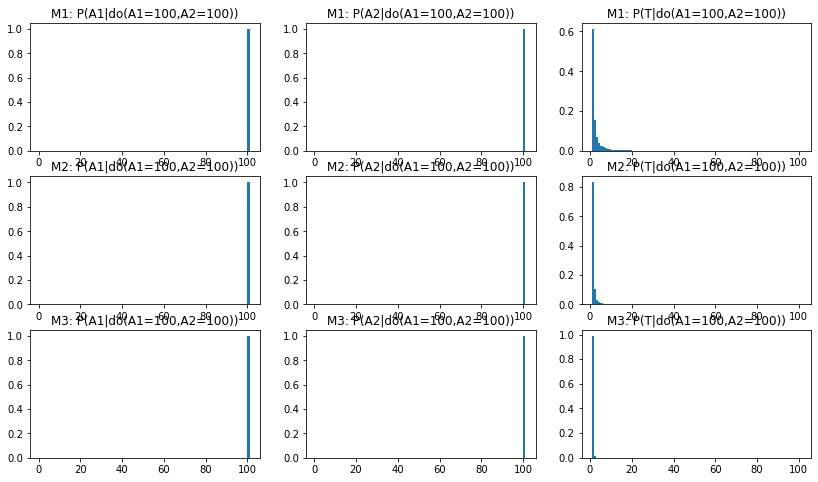

In [35]:
fig,ax = plt.subplots(3,3, figsize=(14,8))

ax[0,0].hist(data0_do[:,0],bins=np.array(list(range(101)))+1,density=True)
ax[0,0].set_title('M1: P(A1|do(A1=100,A2=100))')

ax[0,1].hist(data0_do[:,1],bins=np.array(list(range(101)))+1,density=True)
ax[0,1].set_title('M1: P(A2|do(A1=100,A2=100))')

ax[0,2].hist(data0_do[:,2],bins=np.array(list(range(101)))+1,density=True)
ax[0,2].set_title('M1: P(T|do(A1=100,A2=100))')

ax[1,0].hist(data1_do[:,0],bins=np.array(list(range(101)))+1,density=True)
ax[1,0].set_title('M2: P(A1|do(A1=100,A2=100))')

ax[1,1].hist(data1_do[:,1],bins=np.array(list(range(101)))+1,density=True)
ax[1,1].set_title('M2: P(A2|do(A1=100,A2=100))')

ax[1,2].hist(data1_do[:,2],bins=np.array(list(range(101)))+1,density=True)
ax[1,2].set_title('M2: P(T|do(A1=100,A2=100))')

ax[2,0].hist(data2_do[:,0],bins=np.array(list(range(101)))+1,density=True)
ax[2,0].set_title('M3: P(A1|do(A1=100,A2=100))')

ax[2,1].hist(data2_do[:,1],bins=np.array(list(range(101)))+1,density=True)
ax[2,1].set_title('M3: P(A2|do(A1=100,A2=100))')

ax[2,2].hist(data2_do[:,2],bins=np.array(list(range(101)))+1,density=True)
ax[2,2].set_title('M3: P(T|do(A1=100,A2=100))')

As before, $P(A1 \vert do(A1=100,A2=100))$ and $P(A1 \vert do(A1=100,A2=100))$ are trivially identical for all models.

$P(T \vert do(A1=100,A2=100))$, instead, shows a different distribution.

# Evaluating abstraction error

Exactly as before we will evaluate distances along the upper and lower path of the following diagram:

$$
\begin{array}{ccc}
\mathcal{\mathcal{M}}\left[A1,A2\right] & \overset{\mathcal{\mathcal{M}}\left[\phi_{T}\right]}{\longrightarrow} & \mathcal{\mathcal{M}}\left[T\right]\\
\sideset{}{\alpha_{A1,A2}}\downarrow &  & \sideset{}{\alpha_{T}}\downarrow\\
\mathcal{\mathcal{M}}'\left[A1,A2\right] & \overset{\mathcal{\mathcal{M}}'\left[\phi_{T}\right]}{\longrightarrow} & \mathcal{\mathcal{M}}'\left[T\right]
\end{array}
$$
 
with the knowledge that $\alpha_{A1,A2}$ and $\alpha_{T}$ are identities.

## KL divergence

We can now quantitatively evaluate the difference between $ P_{\mathcal{M}}(T \vert do(A1=100,A2=100)) $, $P_{\mathcal{M'}}(T \vert do(A1=100,A2=100))$ and $P_{\mathcal{M''}}(T \vert do(A1=100,A2=100))$ computing the (empirical) KL divergence.
Let us first compute the *empirical* distributions for $\mathcal{M''}$ and compute the KL divergence from $\mathcal{M'}$ to $\mathcal{M''}$:
$$D_{KL}( \hat{P}_{\mathcal{M'}}(T \vert do) \parallel \hat{P}_{\mathcal{M}''}(T \vert do))$$.

0.38111891699109246


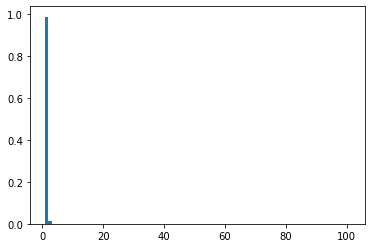

In [36]:
p_M2 = plt.hist(data2_do[:,2],bins=np.array(list(range(101)))+1,density=True)[0]

domain = np.where(p_M2!=0)

KL_M1_M2 = scipy.stats.entropy(p_M1[domain],p_M2[domain])
print(KL_M1_M2)

Again, the KL divergence we compute is very close to the value of $0.39$ in [Rischel2021].

## JSD distance
We now repeat the above analysis for the JSD distance using the empirical distributions estimated above. We first compute the distance between $\mathcal{M}'$ and $\mathcal{M}''$:
$$D_{JSD}( \hat{P}_{\mathcal{M'}}(T \vert do), \hat{P}_{\mathcal{M}''}(T \vert do))$$

In [37]:
JSD_M1_M2 = distance.jensenshannon(p_M1,p_M2)
print(JSD_M1_M2)

0.2151218853041973


## Wasserstein distance
Last we conduct the comparison using the Wasserstein distance. We start by computing the distance between $\mathcal{M}'$ and $\mathcal{M}''$:
$$D_{W}( \hat{P}_{\mathcal{M}'}(T \vert do), \hat{P}_{\mathcal{M}''}(T \vert do))$$

In [38]:
WD_M1_M2 = stats.wasserstein_distance(p_M1,p_M2)
print(WD_M1_M2)

0.0031672200000000027


# Evaluating composed abstraction

Now that we have computed the abstraction errors $e_1$ from $\mathcal{M}$ to $\mathcal{M'}$ and $e_2$ from $\mathcal{M'}$ to $\mathcal{M''}$, we can compare the sum of these distances with the direct distance $e_0$ from $\mathcal{M}$ to $\mathcal{M''}, and verify if $e_1 + e_2$ provides a bound for $e_0$.

## KL distance

Let us start with KL distance. We can assess the composed KL divergence as:
$$D_{KL}( \hat{P}_{\mathcal{M}}(T \vert do) \parallel \hat{P}_{\mathcal{M}'}(T \vert do))+
D_{KL}( \hat{P}_{\mathcal{M'}}(T \vert do) \parallel \hat{P}_{\mathcal{M}''}(T \vert do))$$

In [39]:
print(KL_M0_M1 + KL_M1_M2)

0.5987167613033828


And try to compare it with the KL divergence from $\mathcal{M}$ directly to $\mathcal{M''}$:
$$
D_{KL}( \hat{P}_{\mathcal{M}}(T \vert do) \parallel \hat{P}_{\mathcal{M}''}(T \vert do))
$$

In [40]:
KL_M0_M2 = scipy.stats.entropy(p_M0[domain],p_M2[domain])
print(KL_M0_M2)

1.4205480999102162


This value is also close to the value of $1.52$ computed in [Rischel2021], and indeed it confirms that KL divergences do not compose to provide an upper bound for the distance between distributions of interest in different models, that is:
$$ D_{KL}( P_{\mathcal{M}}(T \vert do) \parallel P_{\mathcal{M}''}(T \vert do)) > 
   D_{KL}( P_{\mathcal{M}}(T \vert do) \parallel P_{\mathcal{M}'}(T \vert do)) + 
   D_{KL}( P_{\mathcal{M}'}(T \vert do) \parallel P_{\mathcal{M}''}(T \vert do)).$$

## JSD distance

We can now evaluate the composed distance using JSD distance from $\mathcal{M}$ to $\mathcal{M}''$:
$$D_{JSD}( \hat{P}_{\mathcal{M}}(T \vert do), \hat{P}_{\mathcal{M}'}(T \vert do))+
D_{JSD}( \hat{P}_{\mathcal{M}'}(T \vert do), \hat{P}_{\mathcal{M}''}(T \vert do))$$

In [41]:
print(JSD_M0_M1 + JSD_M1_M2)

0.41423966942718327


And then compute directly the JSD distance from $\mathcal{M}$ to $\mathcal{M}''$:
$$D_{JSD}( \hat{P}_{\mathcal{M}}(T \vert do), \hat{P}_{\mathcal{M}''}(T \vert do))$$

In [42]:
JSD_M0_M2 = distance.jensenshannon(p_M0,p_M2)
print(JSD_M0_M2)

0.37158968973860923


In this case composition seems to hold in the sense that we can estimate an upper bound on the error (wrt to the distribution of interest) of the direct abstraction (from $\mathcal{M}$ to $\mathcal{M}''$) through the composition of the error of intermediate abstractions:
$$ D_{JSD}( P_{\mathcal{M}}(T \vert do), P_{\mathcal{M}''}(T \vert do)) \leq 
   D_{JSD}( P_{\mathcal{M}}(T \vert do), P_{\mathcal{M}'}(T \vert do)) + 
   D_{JSD}( P_{\mathcal{M}'}(T \vert do), P_{\mathcal{M}''}(T \vert do)).$$

## Wasserstein distance

Finally we evaluate the composed Wasserstein distance from $\mathcal{M}$ to $\mathcal{M}''$:
$$D_{W}( \hat{P}_{\mathcal{M}}(T \vert do), \hat{P}_{\mathcal{M}'}(T \vert do))+
D_{W}( \hat{P}_{\mathcal{M}'}(T \vert do), \hat{P}_{\mathcal{M}''}(T \vert do))$$

In [43]:
print(WD_M0_M1+WD_M1_M2)

0.007517540000000006


And compare to the Wasserstein distance from $\mathcal{M}$ to $\mathcal{M}''$:
$$D_{W}( \hat{P}_{\mathcal{M}}(T \vert do), \hat{P}_{\mathcal{M}''}(T \vert do))$$

In [44]:
WD_M0_M2 = stats.wasserstein_distance(p_M0,p_M2)
print(WD_M0_M2)

0.007517540000000006


Interestingly, the two distance are equivalent, thus actually satisfying our requirement of bound on the error:
$$ D_{W}( P_{\mathcal{M}}(T \vert do), P_{\mathcal{M}''}(T \vert do)) \leq 
   D_{W}( P_{\mathcal{M}}(T \vert do), P_{\mathcal{M}'}(T \vert do)) + 
   D_{W}( P_{\mathcal{M}'}(T \vert do), P_{\mathcal{M}''}(T \vert do)).$$

# Theoretical Considerations

We have measured the *abstraction error* between SCM models as a *statistical distance* wrt to a interventional distirbution of interest $P(T\vert do)$. Our desideratum was to have a property of consistent composition between *abstraction errors*.

As explained in Section 2.4 of [Rischel2021], the critical requirement to have the property we desire is the existence of a bound on the composition of distances of the following form: given a distance $D$, $\forall p_1, p_2, p_3$ we want $D(p_1,p_3)^t \leq D(p_1,p_2)^t + D(p_2,p_3)^t$.

A specific case of this property for $t=1$ is the *triangle inequality*. All proper metrics (like JSD or Wasserstein) satisfy this requirement, but not the KL distance. 

# Conclusion

## Bibliography

[Rischel2021] Rischel, Eigil F., and Sebastian Weichwald. "Compositional Abstraction Error and a Category of Causal Models." arXiv preprint arXiv:2103.15758 (2021).

[Rischel2020] Rischel, Eigil Fjeldgren. "The Category Theory of Causal Models." (2020).

[Rubenstein2017] Rubenstein, Paul K., et al. "Causal consistency of structural equation models." arXiv preprint arXiv:1707.00819 (2017).

[Pearl2009] Pearl, Judea. Causality. Cambridge university press, 2009.

[Peters2017] Peters, Jonas, Dominik Janzing, and Bernhard Schölkopf. Elements of causal inference: foundations and learning algorithms. The MIT Press, 2017.

[Spivak2014] Spivak, David I. Category theory for the sciences. MIT Press, 2014.

[Fong2018] Fong, Brendan, and David I. Spivak. "Seven sketches in compositionality: An invitation to applied category theory." arXiv preprint arXiv:1803.05316 (2018).

(**TODO**: work more on the theoretical justifications for different metrics.)